In [ ]:
pip install pandas scikit-learn xgboost shap

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\dell\appdata\roaming\python\python312\site-packages (2.2.3)




[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Feature Engineering (new features like BMI_Category, Age_Group)
2. Label Encoding for categorical variables
3. Standard Scaling of features
4. SMOTE (oversampling the minority class)
5. Hyperparameter Tuning with GridSearchCV (Random Forest)
6. Using class_weight and scale_pos_weight for imbalance handling
7. Training two models (Random Forest and XGBoost)
8. Model Evaluation (ROC AUC, classification report, confusion matrix)
9. Feature Importance analysis (Random Forest)

PREDICTION WITH FEATURE IMPORTANCE GRAPH SHAP VALUE

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Step 2: Load Dataset
df = pd.read_csv("personalized_medication_dataset.csv")

In [ ]:
# Step 3: Initial Data Overview
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# Focused Missing Value Analysis
missing_cols = ['Chronic_Conditions', 'Drug_Allergies', 'Genetic_Disorders', 'Recommended_Medication', 'Dosage', 'Duration']
missing_counts = df[missing_cols].isnull().sum()

print("\nMissing Values Before Cleaning (Selected Columns):\n", missing_counts)
print("\nTotal Missing Values (Sum of Selected Columns):", missing_counts.sum())


print("\nSummary Statistics (Numerical Columns):\n", df.describe())


Dataset Shape: (1000, 17)

Data Types:
 Patient_ID                  object
Age                          int64
Gender                      object
Weight_kg                  float64
Height_cm                  float64
BMI                        float64
Chronic_Conditions          object
Drug_Allergies              object
Genetic_Disorders           object
Diagnosis                   object
Symptoms                    object
Recommended_Medication      object
Dosage                      object
Duration                    object
Treatment_Effectiveness     object
Adverse_Reactions           object
Recovery_Time_Days           int64
dtype: object

Missing Values Before Cleaning (Selected Columns):
 Chronic_Conditions        246
Drug_Allergies            324
Genetic_Disorders         339
Recommended_Medication    263
Dosage                    195
Duration                  257
dtype: int64

Total Missing Values (Sum of Selected Columns): 1624

Summary Statistics (Numerical Columns):
          

In [ ]:
# Step 4: Create Target Variable (Hypertension)
df['HBP'] = df['Chronic_Conditions'].apply(lambda x: 1 if 'Hypertension' in str(x) else 0)


In [ ]:
# Step 5: Feature Engineering
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

def age_group(age):
    if age < 30: return 'Young'
    elif age < 60: return 'Middle-aged'
    else: return 'Senior'

df['BMI_Category'] = df['BMI'].apply(bmi_category)
df['Age_Group'] = df['Age'].apply(age_group)

df.head

<bound method NDFrame.head of     Patient_ID  Age  Gender  Weight_kg  Height_cm   BMI Chronic_Conditions  \
0        P0001   78   Other       88.7      196.3  21.1                NaN   
1        P0002   57  Female       90.5      195.6  30.2       Hypertension   
2        P0003   29  Female       87.0      168.2  27.0                NaN   
3        P0004   56  Female       81.4      188.9  26.9       Hypertension   
4        P0005   90    Male       64.2      157.0  33.3                NaN   
..         ...  ...     ...        ...        ...   ...                ...   
995      P0996   37    Male       99.1      159.2  26.8           Diabetes   
996      P0997   28   Other      102.8      178.7  34.1             Asthma   
997      P0998   67    Male       58.1      198.1  20.4             Asthma   
998      P0999   79    Male       51.1      171.9  25.8       Hypertension   
999      P1000   70   Other       62.4      199.8  25.4             Asthma   

    Drug_Allergies   Genetic_Diso

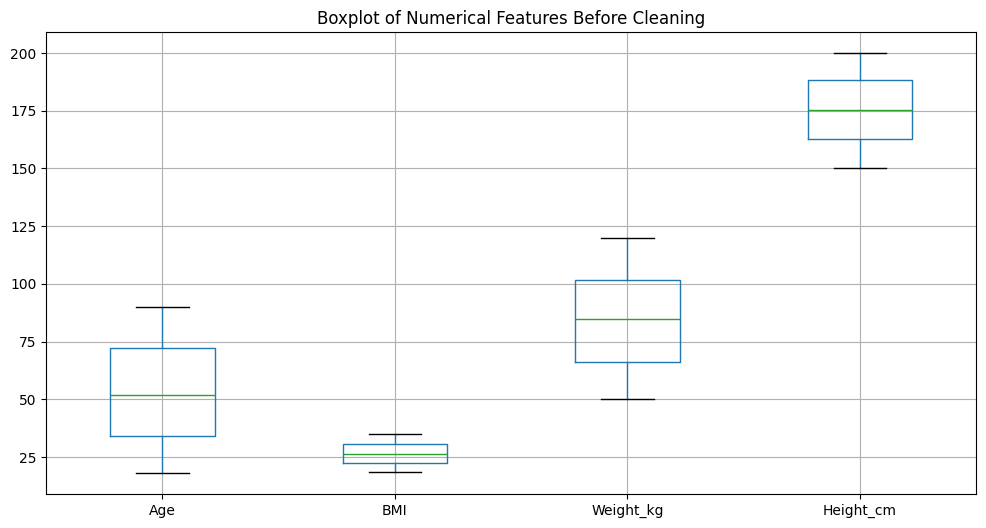

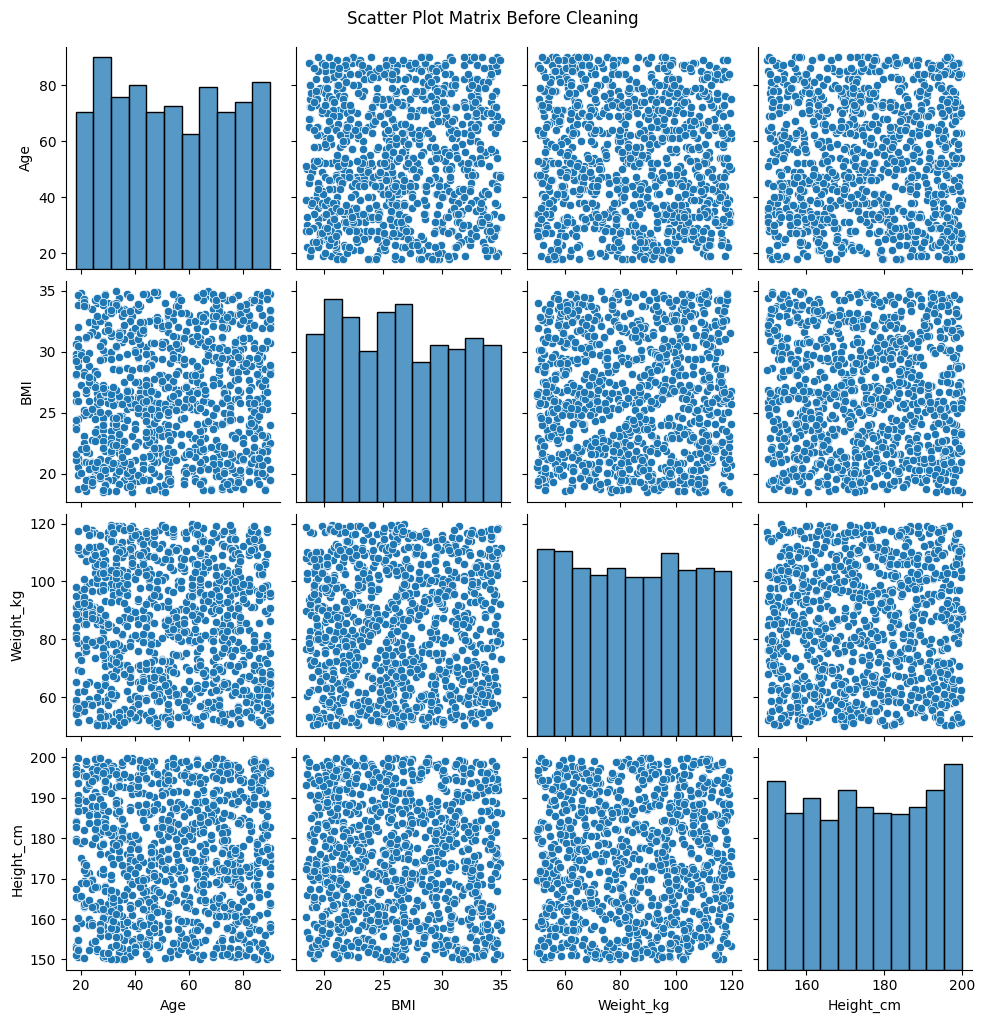

In [ ]:
# Step 6: Check for Outliers (Before Cleaning)
plt.figure(figsize=(12, 6))
df[['Age', 'BMI', 'Weight_kg', 'Height_cm']].boxplot()
plt.title("Boxplot of Numerical Features Before Cleaning")
plt.show()

# Scatter Plot Matrix Before Cleaning
sns.pairplot(df[['Age', 'BMI', 'Weight_kg', 'Height_cm']])
plt.suptitle("Scatter Plot Matrix Before Cleaning", y=1.02)
plt.show()

In [ ]:
# Step 7: Handle Missing Values
# Fill numeric with median and categorical with mode
df.fillna(df.median(numeric_only=True), inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing Values After Cleaning (Selected Columns):\n", df[missing_cols].isnull().sum())



Missing Values After Cleaning (Selected Columns):
 Chronic_Conditions        0
Drug_Allergies            0
Genetic_Disorders         0
Recommended_Medication    0
Dosage                    0
Duration                  0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_316\2894601598.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
# Step 8: Remove Outliers using IQR and count them
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers.shape[0]

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Keep track of size before and after
print("\nDataset Size Before Outlier Removal:", df.shape)

# Count and remove outliers
total_outliers = 0
for col in ['Age', 'BMI', 'Weight_kg', 'Height_cm']:
    outlier_count = count_outliers(df, col)
    total_outliers += outlier_count
    print(f"{col} - Outliers: {outlier_count}")
    df = remove_outliers(df, col)

print("Total Outliers Removed (may include same row multiple times):", total_outliers)
print("Dataset Size After Outlier Removal:", df.shape)



Dataset Size Before Outlier Removal: (1000, 20)
Age - Outliers: 0
BMI - Outliers: 0
Weight_kg - Outliers: 0
Height_cm - Outliers: 0
Total Outliers Removed (may include same row multiple times): 0
Dataset Size After Outlier Removal: (1000, 20)


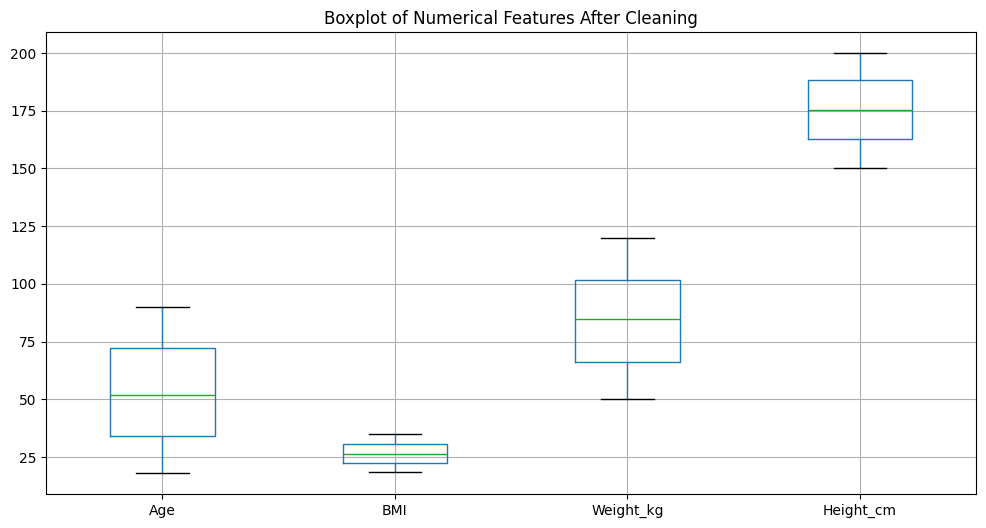

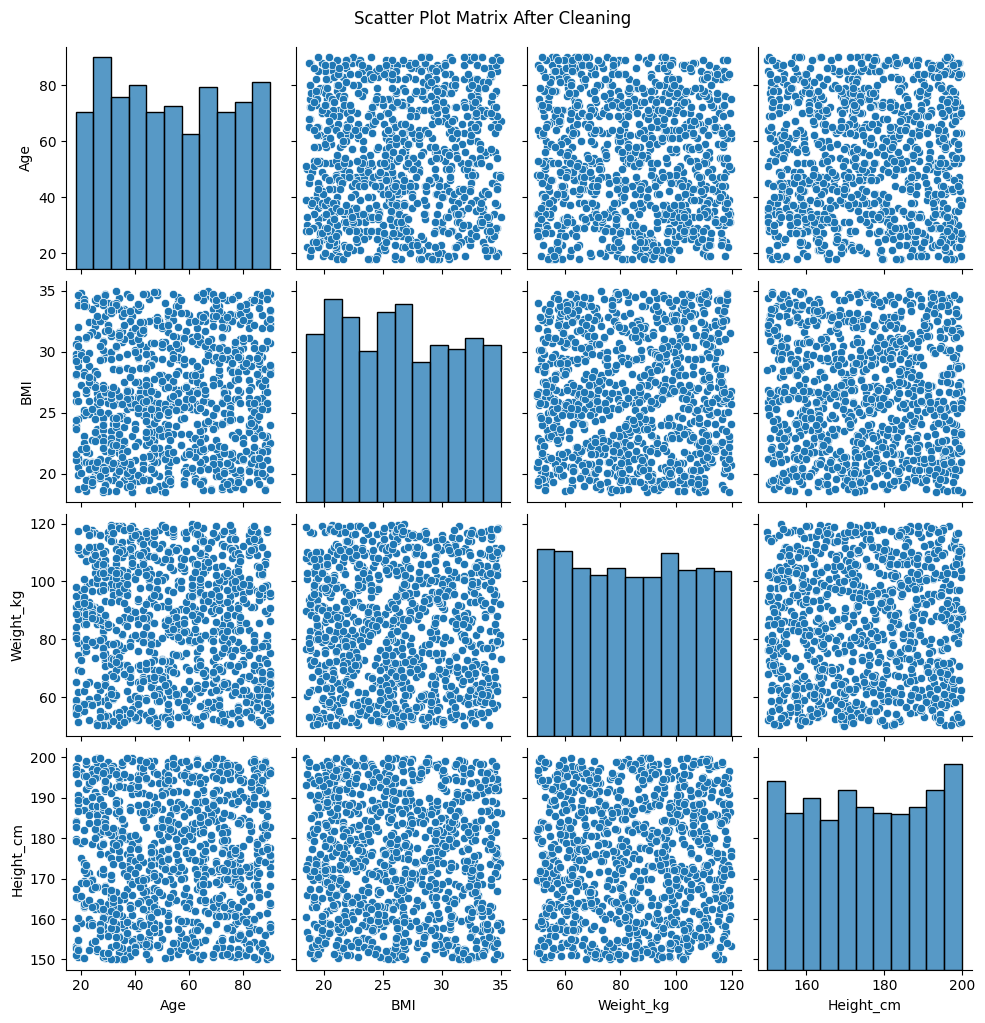

In [ ]:
# Step 9: Visualize Cleaned Numerical Features
plt.figure(figsize=(12, 6))
df[['Age', 'BMI', 'Weight_kg', 'Height_cm']].boxplot()
plt.title("Boxplot of Numerical Features After Cleaning")
plt.show()

# Scatter Plot Matrix After Cleaning
sns.pairplot(df[['Age', 'BMI', 'Weight_kg', 'Height_cm']])
plt.suptitle("Scatter Plot Matrix After Cleaning", y=1.02)
plt.show()

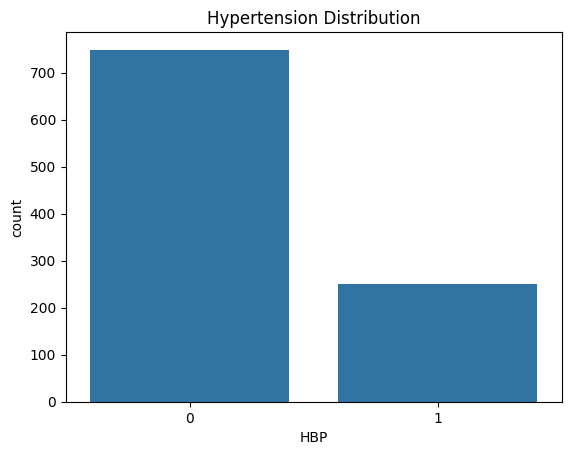

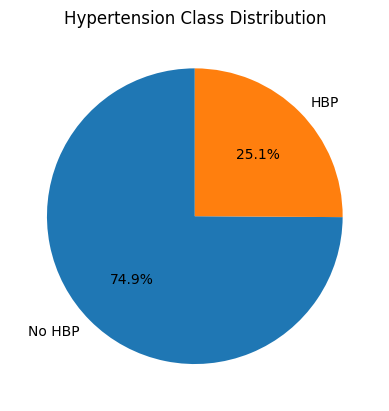

In [ ]:
# Step 10: Visualize Target Distribution
sns.countplot(x='HBP', data=df)
plt.title("Hypertension Distribution")
plt.show()

df['HBP'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['No HBP', 'HBP'])
plt.title("Hypertension Class Distribution")
plt.ylabel('')
plt.show()


Correlation Matrix:

                         Age  Weight_kg  Height_cm       BMI  \
Age                 1.000000  -0.033632   0.012863  0.030844   
Weight_kg          -0.033632   1.000000   0.018386 -0.017339   
Height_cm           0.012863   0.018386   1.000000 -0.030034   
BMI                 0.030844  -0.017339  -0.030034  1.000000   
Recovery_Time_Days -0.019020  -0.001331   0.003744 -0.036376   
HBP                -0.025425  -0.034639   0.004975  0.003520   

                    Recovery_Time_Days       HBP  
Age                          -0.019020 -0.025425  
Weight_kg                    -0.001331 -0.034639  
Height_cm                     0.003744  0.004975  
BMI                          -0.036376  0.003520  
Recovery_Time_Days            1.000000  0.005899  
HBP                           0.005899  1.000000  


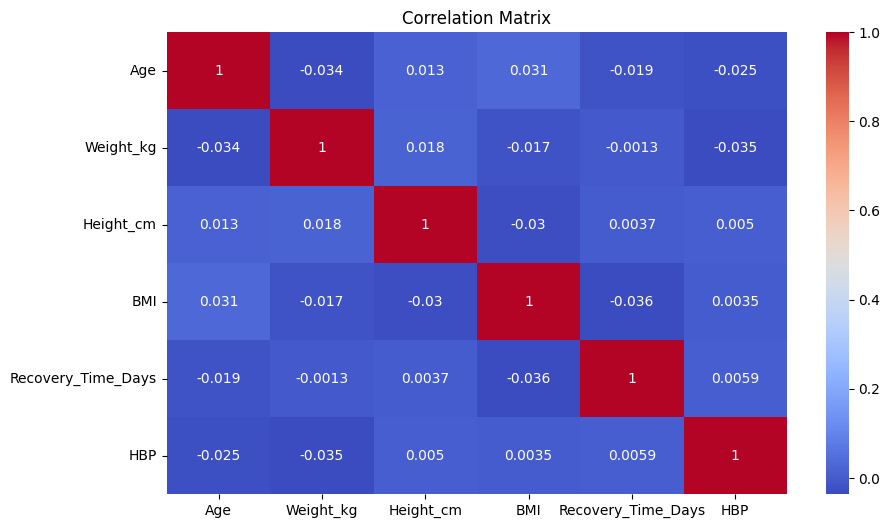

In [ ]:
# Step 11: Correlation Matrix

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Print the correlation matrix
print("Correlation Matrix:\n")
print(correlation_matrix)

numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Step 12: Select Features for Modeling
features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
X = df[features].copy()
y = df['HBP']

# Step 13: Encode Categorical Features
categorical_cols = ['Gender', 'Genetic_Disorders', 'BMI_Category', 'Age_Group']
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Step 14: Normalize / Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 15: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Final Output of Preprocessing
print("\nPreprocessing Complete.\n")
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)
print("Target Variable Distribution:\n", y.value_counts())


Preprocessing Complete.

Training Set Shape: (800, 8)
Test Set Shape: (200, 8)
Target Variable Distribution:
 HBP
0    749
1    251
Name: count, dtype: int64


Original class distribution:
 HBP
0    599
1    201
Name: count, dtype: int64

Resampled class distribution:
 HBP
0    599
1    599
Name: count, dtype: int64

Number of samples added by SMOTE:
 HBP
0      0
1    398
Name: count, dtype: int64


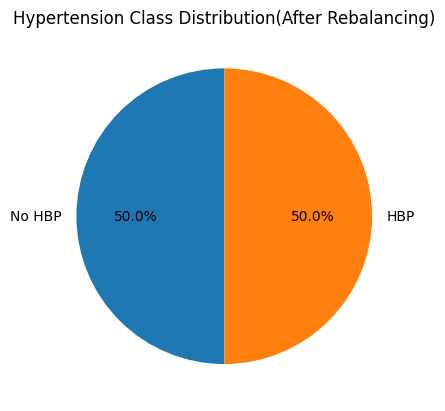

Random Forest ROC AUC: 0.4662666666666667
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75       150
           1       0.13      0.10      0.11        50

    accuracy                           0.60       200
   macro avg       0.42      0.44      0.43       200
weighted avg       0.57      0.60      0.59       200

Random Forest Confusion Matrix:
 [[116  34]
 [ 45   5]]
XGBoost ROC AUC: 0.44026666666666664
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68       150
           1       0.22      0.30      0.25        50

    accuracy                           0.56       200
   macro avg       0.48      0.47      0.47       200
weighted avg       0.60      0.56      0.58       200


Feature Importances (Random Forest):
Age: 0.2014
Height_cm: 0.1977
Weight_kg: 0.1948
BMI: 0.1887
Gender: 0.0928
BMI_Category: 0.0484
Genetic

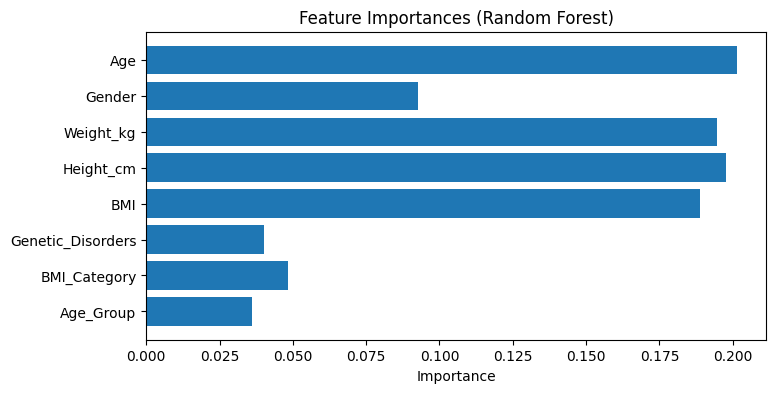

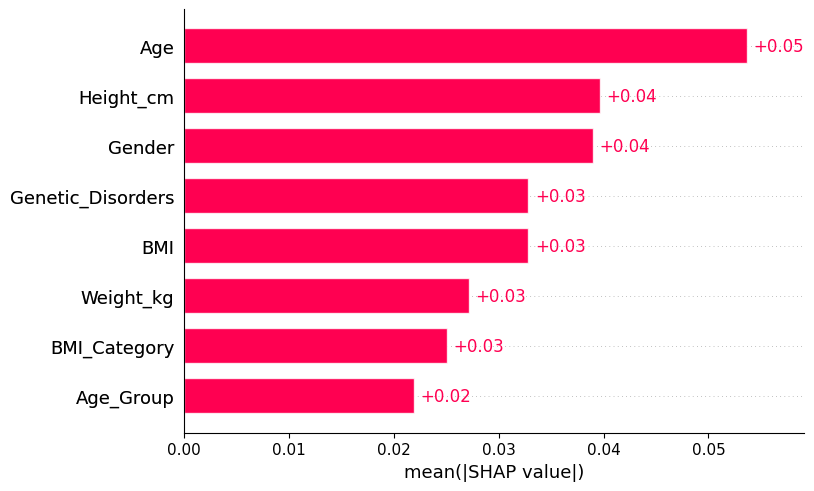

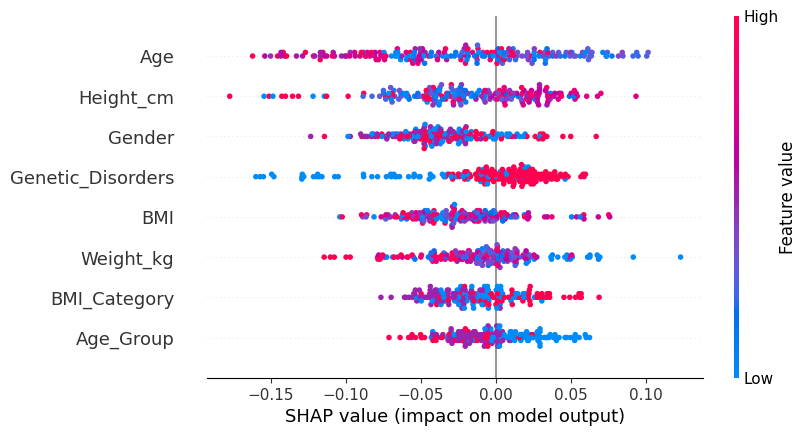

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt


# Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Before SMOTE
original_counts = pd.Series(y_train).value_counts()
print("Original class distribution:\n", original_counts)

# After SMOTE
resampled_counts = pd.Series(y_train_resampled).value_counts()
print("\nResampled class distribution:\n", resampled_counts)

# Number of samples added
added_samples = resampled_counts - original_counts
print("\nNumber of samples added by SMOTE:\n", added_samples)
resampled_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=['No HBP', 'HBP'])
plt.title("Hypertension Class Distribution(After Rebalancing)")
plt.ylabel('')
plt.show()

# Step 10: Hyperparameter tuning using GridSearchCV (Random Forest)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Step 11: Train Random Forest with GridSearchCV
grid_search_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_search_rf.best_estimator_

# Step 12: Evaluate Random Forest
y_pred_rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_probs)

print("Random Forest ROC AUC:", roc_auc_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, best_rf.predict(X_test_scaled)))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, best_rf.predict(X_test_scaled)))

# Step 13: Train XGBoost Classifier
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 14: Evaluate XGBoost
y_pred_xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_probs)

print("XGBoost ROC AUC:", roc_auc_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_model.predict(X_test_scaled)))

# Step 15: Feature Importance (Random Forest)
importances = best_rf.feature_importances_
feature_names = X.columns

print("\nFeature Importances (Random Forest):")
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.4f}")

# Plot Feature Importances
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()
# Step 16: Explainable AI (SHAP) - For Random Forest

# Wrap test set in DataFrame with feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(best_rf)
shap_values = explainer(X_test_scaled_df)

# Convert to Explanation object for class 1 (positive class)
shap_values_class1 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=X_test_scaled_df,
    feature_names=feature_names
)

# SHAP summary bar plot showing mean magnitude & direction
shap.plots.bar(shap_values_class1)
plt.show()

# OPTIONAL: Beeswarm plot to see full SHAP distribution
shap.plots.beeswarm(shap_values_class1)
plt.show()


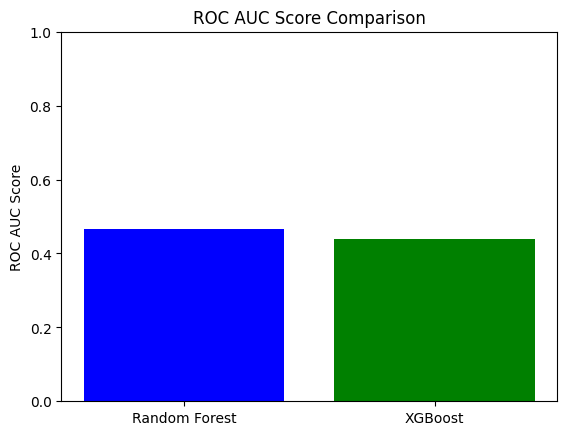

In [ ]:
models = ['Random Forest', 'XGBoost']
roc_scores = [roc_auc_rf, roc_auc_xgb]

plt.bar(models, roc_scores, color=['blue', 'green'])
plt.title('ROC AUC Score Comparison')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Combine and scale full dataset
X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

X_scaled_full = scaler.fit_transform(X_encoded)

# Apply SMOTE on full data
X_resampled_full, y_resampled_full = smote.fit_resample(X_scaled_full, y)

# Retrain best RF model on full balanced dataset using cross-validation
cv_scores_rf = cross_val_score(
    best_rf,
    X_resampled_full,
    y_resampled_full,
    cv=5,
    scoring='f1_macro'
)

print("Final Cross-Validation F1 Scores (Random Forest):", cv_scores_rf)
print("Mean F1 Score (Random Forest):", np.mean(cv_scores_rf))


Final Cross-Validation F1 Scores (Random Forest): [0.68150321 0.74444046 0.84895105 0.82850299 0.85509158]
Mean F1 Score (Random Forest): 0.7916978565181602


In [ ]:
from sklearn.model_selection import cross_val_predict

# Resample full dataset
X_scaled_full = scaler.fit_transform(X)
X_resampled_full, y_resampled_full = smote.fit_resample(X_scaled_full, y)

# === RANDOM FOREST ===
# Cross-validated predictions
y_pred_rf_cv = cross_val_predict(best_rf, X_resampled_full, y_resampled_full, cv=5)

print("Classification Report (Random Forest - Cross-Validated):")
print(classification_report(y_resampled_full, y_pred_rf_cv))
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_resampled_full, y_pred_rf_cv))

# === XGBOOST ===
xgb_model_final = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum()
)

xgb_model_final.fit(X_resampled_full, y_resampled_full)
y_pred_xgb_cv = cross_val_predict(xgb_model_final, X_resampled_full, y_resampled_full, cv=5)

print("\nClassification Report (XGBoost - Cross-Validated):")
print(classification_report(y_resampled_full, y_pred_xgb_cv))
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_resampled_full, y_pred_xgb_cv))


Classification Report (Random Forest - Cross-Validated):
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       749
           1       0.80      0.79      0.79       749

    accuracy                           0.79      1498
   macro avg       0.79      0.79      0.79      1498
weighted avg       0.79      0.79      0.79      1498

Confusion Matrix (Random Forest):
[[597 152]
 [156 593]]

Classification Report (XGBoost - Cross-Validated):
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       749
           1       0.69      0.80      0.74       749

    accuracy                           0.72      1498
   macro avg       0.73      0.72      0.72      1498
weighted avg       0.73      0.72      0.72      1498

Confusion Matrix (XGBoost):
[[487 262]
 [152 597]]


In [ ]:
# === RANDOM FOREST ===
y_rf_probs_cv = cross_val_predict(best_rf, X_resampled_full, y_resampled_full, cv=5, method='predict_proba')[:, 1]
roc_auc_rf_cv = roc_auc_score(y_resampled_full, y_rf_probs_cv)
print(f"Random Forest ROC AUC (CV): {roc_auc_rf_cv:.4f}")

# === XGBOOST ===
y_xgb_probs_cv = cross_val_predict(xgb_model_final, X_resampled_full, y_resampled_full, cv=5, method='predict_proba')[:, 1]
roc_auc_xgb_cv = roc_auc_score(y_resampled_full, y_xgb_probs_cv)
print(f"XGBoost ROC AUC (CV): {roc_auc_xgb_cv:.4f}")


Random Forest ROC AUC (CV): 0.8766
XGBoost ROC AUC (CV): 0.8151
